In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math

In [2]:
# esthetic definitions for the plots
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

dict_keys(['phi', 'psi', 't_cdm', 't_b', 'd_tot', 't_g', 'd_ur', 'd_cdm', 'd_b', 't_tot', 't_ur', 'd_g', 'k (h/Mpc)'])


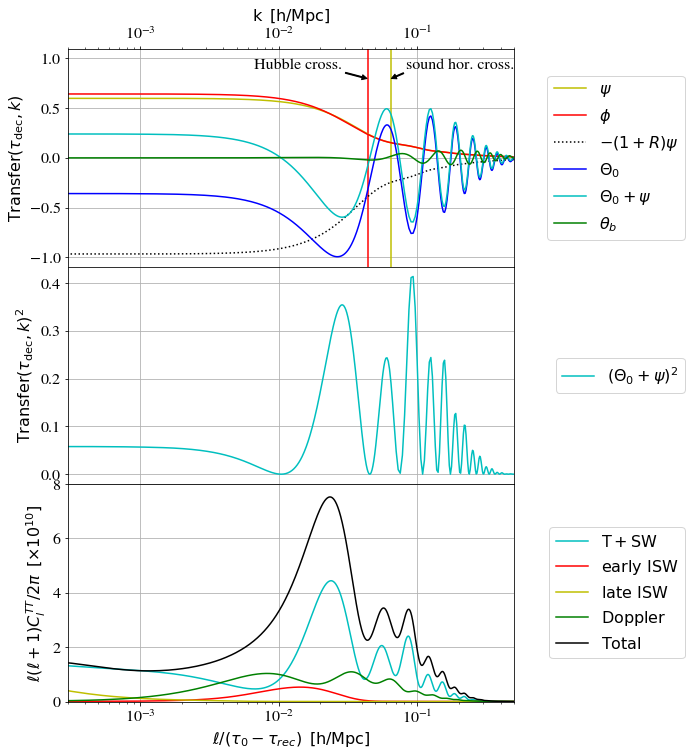

In [3]:
#############################################
#
# Cosmological parameters and other CLASS parameters
#
common_settings = {# wich output? ClTT, transfer functions delta_i and theta_i
                   'output':'tCl,mTk,vTk',
                   # LambdaCDM parameters
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'n_s':0.9619,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
                   # other output and precision parameters
                   'l_max_scalars':5000,
                   'P_k_max_1/Mpc':10.0,
                   'gauge':'newtonian'}
###############
#
# call CLASS a first time just to compute z_rec (will compute transfer functions at default: z=0)
#
M = Class()
M.set(common_settings)
M.compute()
derived = M.get_current_derived_parameters(['z_rec','tau_rec','conformal_age'])
#print derived.viewkeys()
z_rec = derived['z_rec']
z_rec = int(1000.*z_rec)/1000. # round down at 4 digits after coma
M.struct_cleanup()  # clean output
M.empty()           # clean input
#
# call CLASS again (will compute transfer functions at inout value z_rec)
#
M = Class()
M.set(common_settings)
M.set({'z_pk':z_rec})
M.compute()
#
# load transfer functions at recombination
#
one_time = M.get_transfer(z_rec)
print one_time.viewkeys()
k = one_time['k (h/Mpc)']
Theta0 = 0.25*one_time['d_g']
phi = one_time['phi']
psi = one_time['psi']
theta_b = one_time['t_b']
# compute related quantitites
R = 3./4.*M.Omega_b()/M.Omega_g()/(1+z_rec)  # R = 3/4 * (rho_b/rho_gamma) at z_rec
zero_point = -(1.+R)*psi                     # zero point of oscillations: -(1.+R)*psi
#
# get Theta0 oscillation amplitude (for vertical scale of plot)
#
Theta0_amp = max(Theta0.max(),-Theta0.min())
#
# use table of background quantitites to find the wavenumbers corresponding to
# Hubble crossing (k = 2 pi a H), sound horizon crossing (k = 2pi / rs)
#
background = M.get_background() # load background table
#print background.viewkeys()
#
background_tau = background['conf. time [Mpc]'] # read confromal times in background table
background_z = background['z'] # read redshift
background_kh = 2.*math.pi*background['H [1/Mpc]']/(1.+background['z'])/M.h() # read kh = 2pi aH = 2pi H/(1+z) converted to [h/Mpc]
background_ks = 2.*math.pi/background['comov.snd.hrz.']/M.h() # read ks = 2pi/rs converted to [h/Mpc]
#
# define interpolation functions; we want the value of tau when the argument is equal to 2pi
#
kh_at_tau = interp1d(background_tau,background_kh)
ks_at_tau = interp1d(background_tau,background_ks)
#
# finally get these scales
#
tau_rec = derived['tau_rec']
kh = kh_at_tau(tau_rec)
ks = ks_at_tau(tau_rec)
#
#################
#
# start plotting
#
#################
#
fig, (ax_Tk, ax_Tk2, ax_Cl) = plt.subplots(3,sharex=True,figsize=(8,12))
fig.subplots_adjust(hspace=0)
##################
#
# first figure with transfer functions
#
##################
ax_Tk.set_xlim([3.e-4,0.5])
ax_Tk.set_ylim([-1.1*Theta0_amp,1.1*Theta0_amp])
ax_Tk.tick_params(axis='x',which='both',bottom='off',top='on',labelbottom='off',labeltop='on')
ax_Tk.set_xlabel(r'$\mathrm{k} \,\,\,  \mathrm{[h/Mpc]}$')
ax_Tk.set_ylabel(r'$\mathrm{Transfer}(\tau_\mathrm{dec},k)$')
ax_Tk.xaxis.set_label_position('top')
ax_Tk.grid()
#
ax_Tk.axvline(x=kh,color='r')
ax_Tk.axvline(x=ks,color='y')
#
ax_Tk.annotate(r'Hubble cross.',
                xy=(kh,0.8*Theta0_amp),
                xytext=(0.15*kh,0.9*Theta0_amp),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))
ax_Tk.annotate(r'sound hor. cross.',
                 xy=(ks,0.8*Theta0_amp),
                 xytext=(1.3*ks,0.9*Theta0_amp),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))
#
ax_Tk.semilogx(k,psi,'y-',label=r'$\psi$')
ax_Tk.semilogx(k,phi,'r-',label=r'$\phi$')
ax_Tk.semilogx(k,zero_point,'k:',label=r'$-(1+R)\psi$')
ax_Tk.semilogx(k,Theta0,'b-',label=r'$\Theta_0$')
ax_Tk.semilogx(k,(Theta0+psi),'c',label=r'$\Theta_0+\psi$')
ax_Tk.semilogx(k,theta_b,'g-',label=r'$\theta_b$')
#
ax_Tk.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
#######################
#
# second figure with transfer functions squared
#
#######################
ax_Tk2.set_xlim([3.e-4,0.5])
ax_Tk2.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off',labeltop='off')
ax_Tk2.set_ylabel(r'$\mathrm{Transfer}(\tau_\mathrm{dec},k)^2$')
ax_Tk2.grid()
#
ax_Tk2.semilogx(k,(Theta0+psi)**2,'c',label=r'$(\Theta_0+\psi)^2$')
#
ax_Tk2.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
########################
#
# third figure with all contributions to Cls
#
# For that we will need to call CLASS again for each contribution (TSW, earlyISW, lateISW, Doppler, total)
# Note that there is another contribution from polarisation: we don't plot it individually because it is
# too small to be seen, however it is included by default in the total.
#
# After each step we will save the figure (to get intermediate figures for the slides)
#
#########################
# presentation settings
ax_Cl.set_xlim([3.e-4,0.5])
ax_Cl.set_ylim([0.,8.])
ax_Cl.set_xlabel(r'$\ell/(\tau_0-\tau_{rec}) \,\,\, \mathrm{[h/Mpc]}$')
ax_Cl.set_ylabel(r'$\ell (\ell+1) C_l^{TT} / 2 \pi \,\,\, [\times 10^{10}]$')
ax_Cl.tick_params(axis='x',which='both',bottom='on',top='off',labelbottom='on',labeltop='off')
ax_Cl.grid()
#
# the x-axis will show l/(tau_0-tau_rec), so we need (tau_0-tau_rec) in units of [Mpc/h]
#
tau_0_minus_tau_rec_hMpc = (derived['conformal_age']-derived['tau_rec'])*M.h()
#
# save the total Cl's (we will plot them in the last step)
#
cl_tot = M.raw_cl(5000)
#
# call CLASS with TSW, then plot and save
#
M.struct_cleanup()  # clean output
M.empty()           # clean input
M.set(common_settings) # new input
M.set({'temperature contributions':'tsw'})
M.compute()
cl = M.raw_cl(5000)
#
ax_Cl.semilogx(cl['ell']/tau_0_minus_tau_rec_hMpc,1.e10*cl['ell']*(cl['ell']+1.)*cl['tt']/2./math.pi,'c-',label=r'$\mathrm{T+SW}$')
#
ax_Cl.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
fig.savefig('one_time_with_cl_1.pdf',bbox_inches='tight')
#
# call CLASS with early ISW, plot; call CLASS with late ISW, plot; then save
#
M.struct_cleanup()
M.empty()
M.set(common_settings)
M.set({'temperature contributions':'eisw'})
M.compute()
cl = M.raw_cl(5000)
#
ax_Cl.semilogx(cl['ell']/tau_0_minus_tau_rec_hMpc,1.e10*cl['ell']*(cl['ell']+1.)*cl['tt']/2./math.pi,'r-',label=r'$\mathrm{early} \,\, \mathrm{ISW}$')
#
M.struct_cleanup()
M.empty()
M.set(common_settings)
M.set({'temperature contributions':'lisw'})
M.compute()
cl = M.raw_cl(5000)
#
ax_Cl.semilogx(cl['ell']/tau_0_minus_tau_rec_hMpc,1.e10*cl['ell']*(cl['ell']+1.)*cl['tt']/2./math.pi,'y-',label=r'$\mathrm{late} \,\, \mathrm{ISW}$')
#
ax_Cl.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
fig.savefig('one_time_with_cl_2.pdf',bbox_inches='tight')
#
# call CLASS with Doppler, then plot and save
#
M.struct_cleanup()
M.empty()
M.set(common_settings)
M.set({'temperature contributions':'dop'})
M.compute()
cl = M.raw_cl(5000)
#
ax_Cl.semilogx(cl['ell']/tau_0_minus_tau_rec_hMpc,1.e10*cl['ell']*(cl['ell']+1.)*cl['tt']/2./math.pi,'g-',label=r'$\mathrm{Doppler}$')
#
ax_Cl.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
fig.savefig('one_time_with_cl_3.pdf',bbox_inches='tight')
#
# plot the total Cls that had been stored, and save
#
ax_Cl.semilogx(cl_tot['ell']/tau_0_minus_tau_rec_hMpc,1.e10*cl_tot['ell']*(cl_tot['ell']+1.)*cl_tot['tt']/2./math.pi,'k-',label=r'$\mathrm{Total}$')
#
ax_Cl.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
fig.savefig('one_time_with_cl_tot.pdf',bbox_inches='tight')